# IMDB 영화리뷰 감성분석 - LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
import warnings
warnings.filterwarnings('ignore')

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X_train.shape, X_test.shape, y_train.shape

17473536/17464789 [==============================] - 0s 0us/step


((25000,), (25000,), (25000,))

In [3]:
print('등장한 단어수: ', len(imdb.get_word_index()))
print('리뷰 최대 길이: ', max(len(s) for s in X_train))
print('리뷰 평균 길이: ', sum(map(len, X_train))/ len(X_train))

1654784/1641221 [==============================] - 0s 0us/step
등장한 단어수:  88584
리뷰 최대 길이:  2494
리뷰 평균 길이:  238.71364


### LSTM으로 IMDB 리뷰 감성 분석
 - 단어 빈도수 : 10,000 (88,584)
 - 문장의 단어수 : 500 (최대2494)
 - test data 중 40 퍼

In [4]:
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 

In [6]:
num_words = 10000


In [7]:
(X_train, y_train),(X_test, y_test) = imdb.load_data(num_words = num_words)
X_train.shape, X_test.shape, y_train.shape

((25000,), (25000,), (25000,))

In [8]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((25000, 500), (25000, 500))

In [9]:
from sklearn.model_selection import train_test_split
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, stratify=y_test, test_size=0.4, random_state=seed
)
X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

((15000, 500), (15000,), (10000, 500), (10000,))

Case1 ) LSTM
임베딩 차원 벡터 100
은닉층 128

In [10]:
model1 = Sequential([
    Embedding(10000, 100, input_length=max_len ),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [11]:
model1.compile('adam', 'binary_crossentropy',['accuracy'])

model_path = 'best-imdb-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [12]:
hist1 = model1.fit(
    X_train, y_train, epochs=30, validation_split=0.2, batch_size=64,
    validation_data=[X_valid, y_valid],
    callbacks=[mc, es]
)

Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.7872
Epoch 00001: val_loss improved from inf to 0.35855, saving model to best-imdb-lstm.h5
313/313 [==============================] - 204s 646ms/step - loss: 0.4399 - accuracy: 0.7872 - val_loss: 0.3585 - val_accuracy: 0.8500
Epoch 2/30
313/313 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9011
Epoch 00002: val_loss improved from 0.35855 to 0.29986, saving model to best-imdb-lstm.h5
313/313 [==============================] - 205s 656ms/step - loss: 0.2553 - accuracy: 0.9011 - val_loss: 0.2999 - val_accuracy: 0.8820
Epoch 3/30
313/313 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9312
Epoch 00003: val_loss did not improve from 0.29986
313/313 [==============================] - 209s 668ms/step - loss: 0.1933 - accuracy: 0.9312 - val_loss: 0.3317 - val_accuracy: 0.8632
Epoch 4/30
313/313 [==============================] - ETA: 0s - loss: 0.1880 - a

In [14]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

469/469 [==============================] - 53s 112ms/step - loss: 0.3260 - accuracy: 0.8708


[0.3260051906108856, 0.8708000183105469]

In [ ]:
# drop 및 dense 층 추가하면 좋을듯

In [16]:
y_acc = hist1.history['accuracy']
y_vacc = hist1.history['val_accuracy']
y_loss = hist1.history['loss']
y_vloss = hist1.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

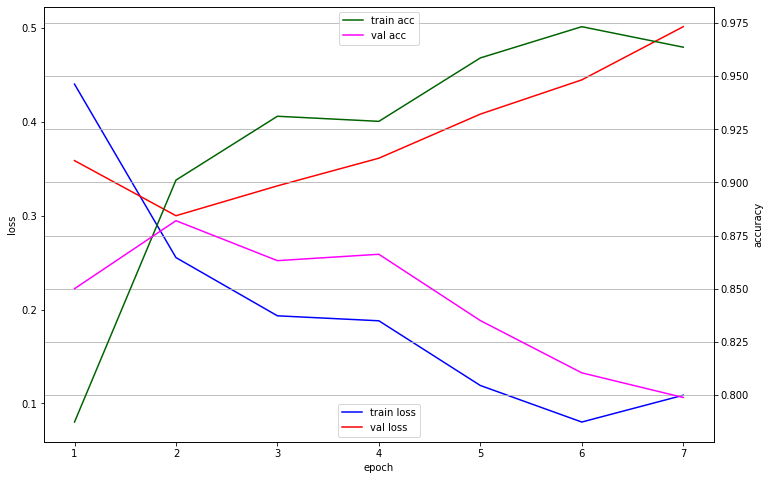

In [17]:
fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c='blue', label='train loss')
ax0.plot(x_len, y_vloss, c='red', label='val loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c='darkgreen', label='train acc')
ax1.plot(x_len, y_vacc, c='magenta', label='val acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center'); ax1.legend(loc='upper center')
plt.grid(); plt.show()